# Dimensionality reduction

Notebook contains training and validation of XGBoost models in basic prediction case - multiclass classification (stages: I, II, III, IV), after dimensionality reduction. Different methods are tried: features preselection using ANOVA and mutual information criteria, and data decomposition using PCA.

In [1]:
import os
import optuna
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from xgboost.sklearn import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.ERROR)

Define random seed to allow reproducibility

In [2]:
random_state = 42
np.random.seed(random_state)

Define directory paths to save results

In [3]:
output_dir_multiclass = '../results/updated_data/stable_features/dimensionality_reduction/multiclass/'
output_dir_binary = '../results/updated_data/stable_features/dimensionality_reduction/binary/'

Load training data

In [4]:
data_path = '../data/cleaned/updated/stable_features/'

train = pd.read_csv(os.path.join(data_path, 'train.csv'), sep=';')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Columns: 762 entries, ID to NDUFA4
dtypes: float64(758), object(4)
memory usage: 5.1+ MB


Prepare data for models training and dimensionality reduction (multiclass classification)

In [5]:
X_train_multiclass = train.copy(deep=True)

stratification_groups_multiclass = X_train_multiclass.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
X_train_multiclass = X_train_multiclass.drop(columns=['ID', 'Sex', 'Age', 'Group'])

scaler = StandardScaler()
y_train_dr_multiclass = X_train_multiclass.loc[:, 'Stage']
X_train_dr_multiclass = scaler.fit_transform(X_train_multiclass.drop(columns=['Stage']))

dr_columns = X_train_multiclass.columns.drop('Stage')
X_train_dr_multiclass = pd.DataFrame(data=X_train_dr_multiclass, columns=dr_columns)

labels_encoding_multiclass = {
    'I': 0,
    'II': 1,
    'III': 2,
    'IV': 3
}
X_train_multiclass.loc[:, 'Stage'] = X_train_multiclass['Stage'].map(labels_encoding_multiclass)

Prepare data for models training and dimensionality reduction (binary classification)

In [6]:
X_train_binary = train.copy(deep=True)

binary_mapping = {
    'I': 'I-III',
    'II': 'I-III',
    'III': 'I-III',
    'IV': 'IV'
}
X_train_binary.loc[:, 'Stage'] = X_train_binary['Stage'].map(binary_mapping)

stratification_groups_binary = X_train_binary.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
X_train_binary = X_train_binary.loc[:, ~X_train_binary.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

scaler = StandardScaler()
y_train_dr_binary = X_train_binary.loc[:, 'Stage']
X_train_dr_binary = scaler.fit_transform(X_train_binary.drop(columns=['Stage']))

dr_columns = X_train_binary.columns.drop('Stage')
X_train_dr_binary = pd.DataFrame(data=X_train_dr_binary, columns=dr_columns)

labels_encoding_binary = {
    'I-III': 0,
    'IV': 1
}
X_train_binary.loc[:, 'Stage'] = X_train_binary['Stage'].map(labels_encoding_binary)

Define a function for selecting features which scores are in the given percentile

In [7]:
def select_by_percentile(scores, percentile):
    threshold = np.percentile(scores, percentile)

    return np.where(scores >= threshold)

Define functions for cross validation

In [8]:
def stratified_cross_val_score(
        estimator,
        df,
        stratification_groups,
        label_col,
        scoring,
        n_splits=5
):
    scores = np.zeros(n_splits)
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (train_index, test_index) in enumerate(skf.split(df, stratification_groups)):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)

        y_true = y.iloc[test_index]
        y_pred = estimator.predict(X.iloc[test_index])
        scores[i] = scoring(list(y_true), y_pred)

    return scores


def stratified_cross_val_predict(
        estimator,
        df,
        stratification_groups,
        label_col,
        n_splits=5
):
    y_pred = np.zeros(len(df))
    skf = StratifiedKFold(n_splits=n_splits)

    for train_index, test_index in skf.split(df, stratification_groups):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)
        y_pred[test_index] = estimator.predict(X.iloc[test_index])

    return y_pred

Define objective function for hyperparameters optimization using Optuna

In [9]:
def objective(trial: optuna.Trial, X_train, stratification_groups, xgb_config, scoring):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        **xgb_config
    }

    xgb = XGBClassifier(**params)

    scores = stratified_cross_val_score(
        estimator=xgb,
        df=X_train,
        stratification_groups=stratification_groups,
        label_col='Stage',
        scoring=scoring,
        n_splits=4
    )

    return scores.mean()

Define function for plotting confusion matrix

In [10]:
def plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=None):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', linewidths=1)
    plt.setp(plt.gca().get_xticklabels(), ha='right', rotation=45)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.title(title, y=1.12, fontsize=12)
    plt.suptitle(scores_subtitle, y=0.08, fontsize=12)

    fig.show()
    
    if output_path is not None:
        fig.savefig(output_path, bbox_inches='tight')

## ANOVA

Preselection of features based on analysis of variance with different percentile thresholds. For each threshold, an XGBoost model is trained, fine-tuned, and cross-validated on the subset of initial columns.

### Multiclass classification

In [11]:
f_scores_multiclass, p_values_multiclass = f_classif(X_train_dr_multiclass, y_train_dr_multiclass)

results_anova_multiclass = pd.DataFrame(data={
    'feature': X_train_dr_multiclass.columns,
    'anova_score': f_scores_multiclass,
    'anova_p_value': p_values_multiclass
})

results_anova_multiclass.sort_values('anova_score', ascending=False).reset_index(drop=True).head(10)

,feature,anova_score,anova_p_value
0,ZNF385D,20.519590,7.504635e-13
1,HPSE,20.299172,1.016998e-12
2,CABP5,19.359041,3.724685e-12
3,TMEM258,19.169369,4.841562e-12
4,NOMO1,18.032903,2.336106e-11
5,MTRNR2L2,17.263910,6.792105e-11
6,H3F3A,17.011469,9.645783e-11
7,MTRNR2L8,15.934853,4.314580e-10
8,HCST,14.598959,2.781020e-09
9,ZNF778,14.556393,2.951372e-09


In [12]:
percentiles = [70, 80, 90, 95, 98]

xgb_config = {
    'objective': 'multi:softmax',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
    'num_class': 4,
}

scoring_func = partial(f1_score, average='weighted')

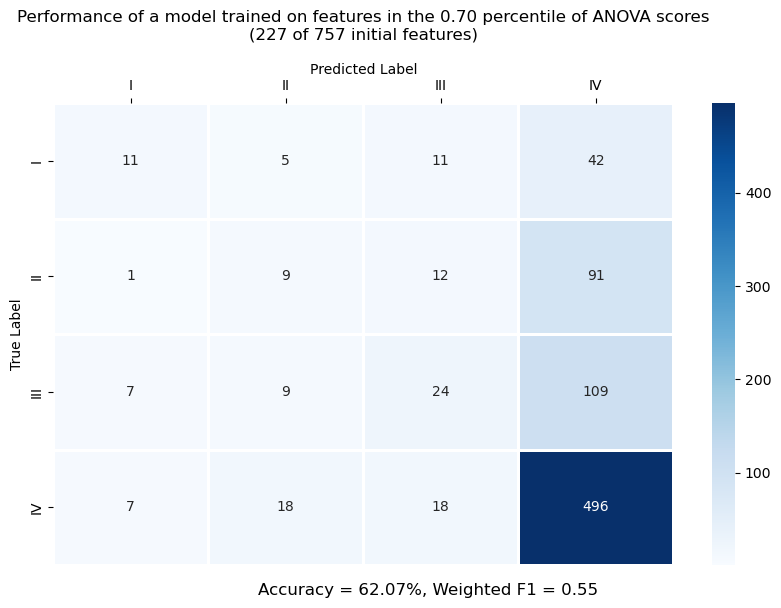

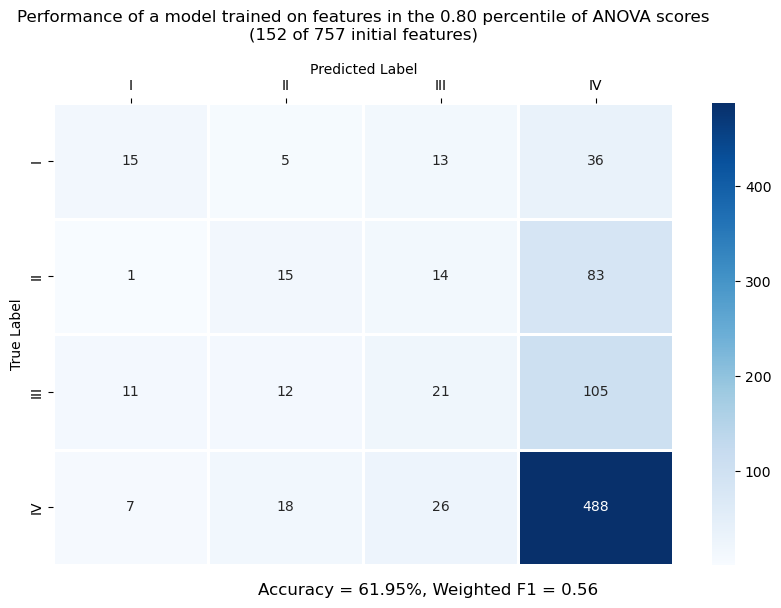

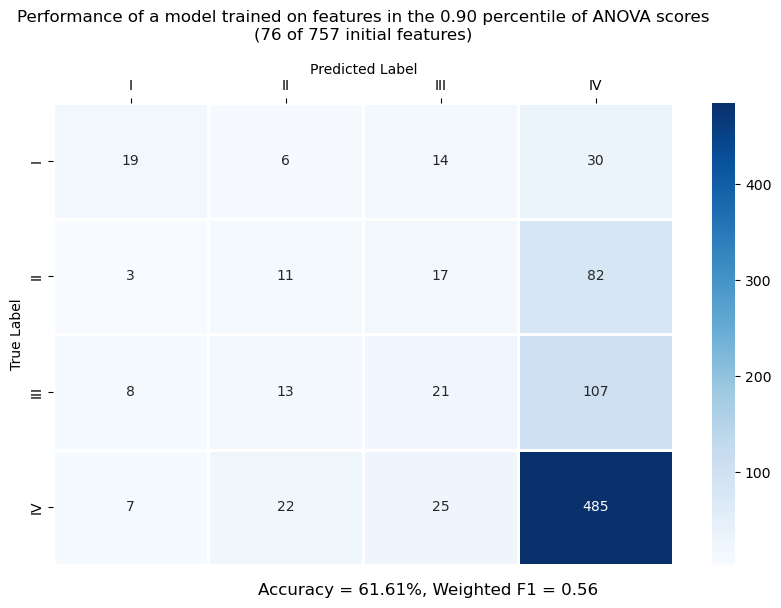

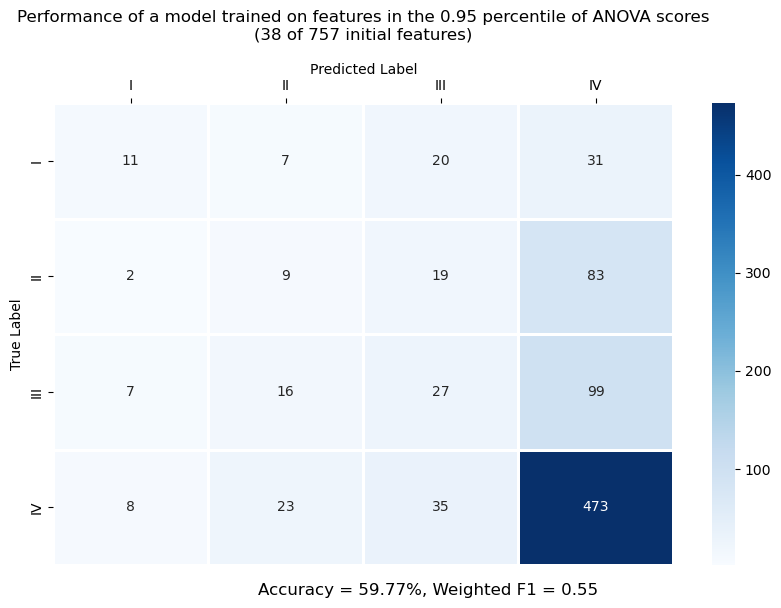

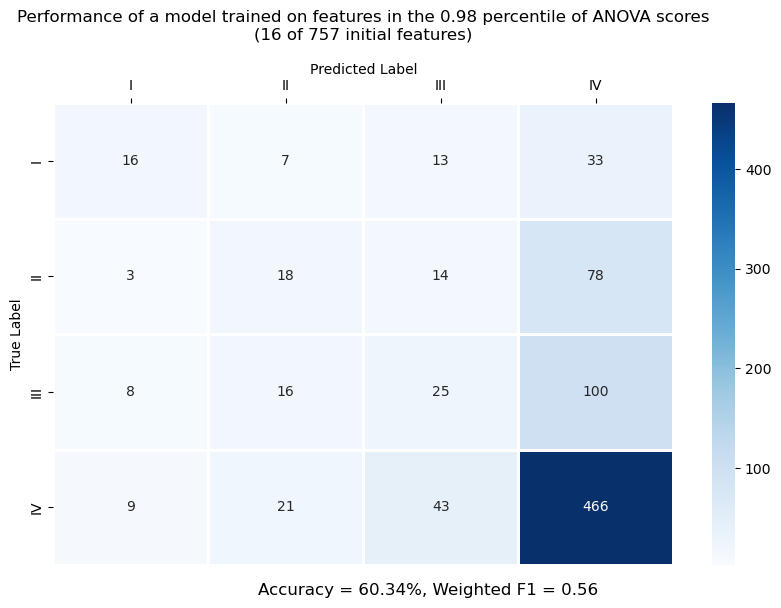

In [13]:
for percentile in percentiles:
    features_indices = select_by_percentile(f_scores_multiclass, percentile)
    best_features = X_train_dr_multiclass.columns[features_indices].tolist()
    X_train_reducted = X_train_multiclass.loc[:, best_features + ['Stage']]

    objective_func = partial(
        objective,
        X_train=X_train_reducted,
        stratification_groups=stratification_groups_multiclass,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reducted,
        stratification_groups=stratification_groups_multiclass,
        label_col='Stage',
        n_splits=5
    )
    y_true = list(X_train_reducted['Stage'].values)
    labels = list(labels_encoding_multiclass.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
    cm = confusion_matrix(y_true, y_pred.astype(int))

    title = f'Performance of a model trained on features in the {percentile/100:.2f} percentile of ANOVA scores' \
            f'\n({len(features_indices[0])} of {len(X_train_dr_multiclass.columns)} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'
    
    filename = f'anova_{percentile}_percentile.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

### Binary classification

In [14]:
f_scores_binary, p_values_binary = f_classif(X_train_dr_binary, y_train_dr_binary)

results_anova_binary = pd.DataFrame(data={
    'feature': X_train_dr_binary.columns,
    'anova_score': f_scores_binary,
    'anova_p_value': p_values_binary
})

results_anova_binary.sort_values('anova_score', ascending=False).reset_index(drop=True).head(10)

,feature,anova_score,anova_p_value
0,CABP5,54.839685,3.095726e-13
1,HPSE,51.569572,1.485824e-12
2,NOMO1,48.531502,6.422387e-12
3,TMEM258,44.131628,5.413648e-11
4,ZNF385D,38.684334,7.736874e-10
5,MTRNR2L2,37.862339,1.158169e-09
6,MTRNR2L8,36.704077,2.046799e-09
7,CA2,34.901603,4.976630e-09
8,H3F3A,33.739928,8.836702e-09
9,GRB14,32.328172,1.778526e-08


In [15]:
percentiles = [70, 80, 90, 95, 98]

xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

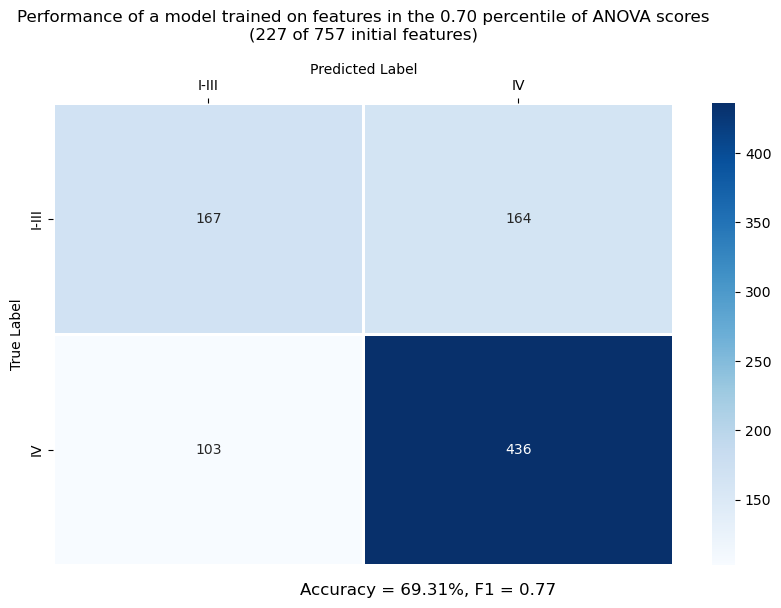

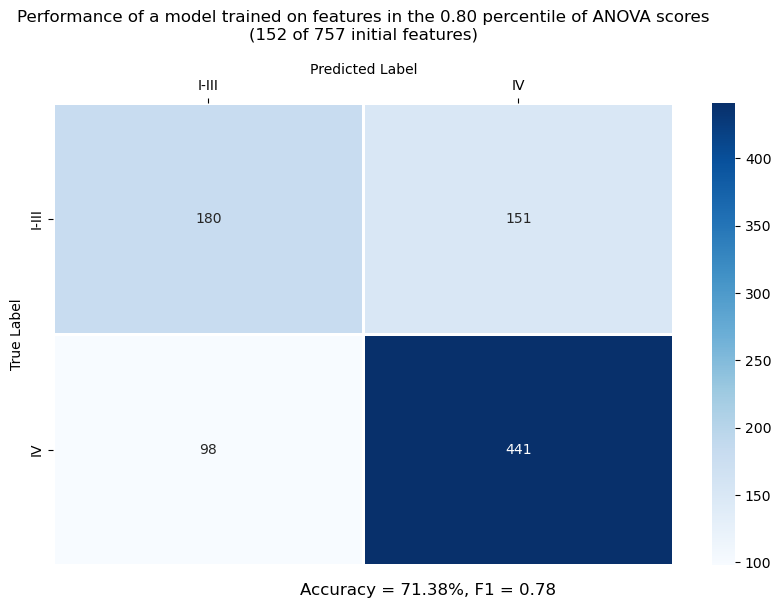

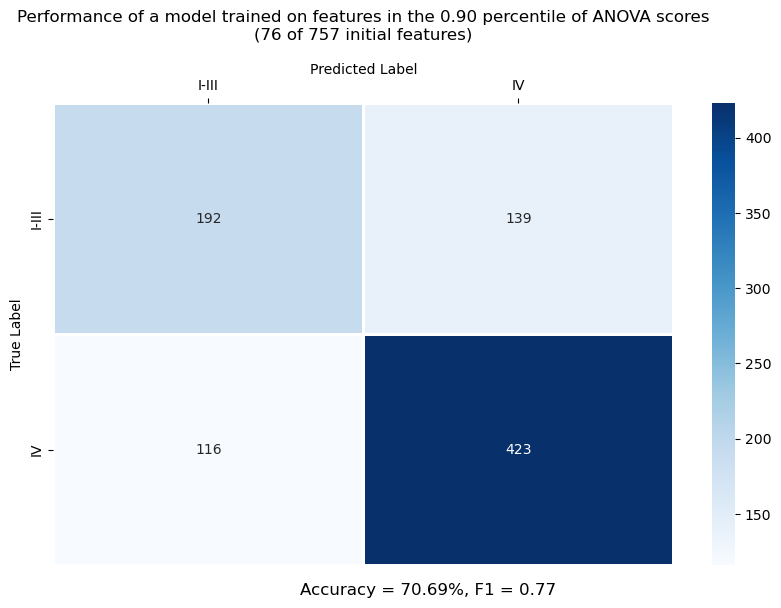

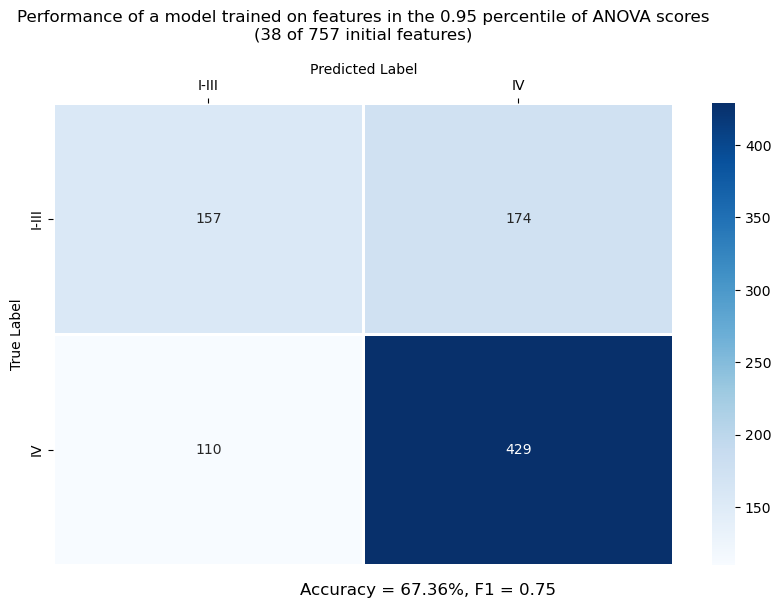

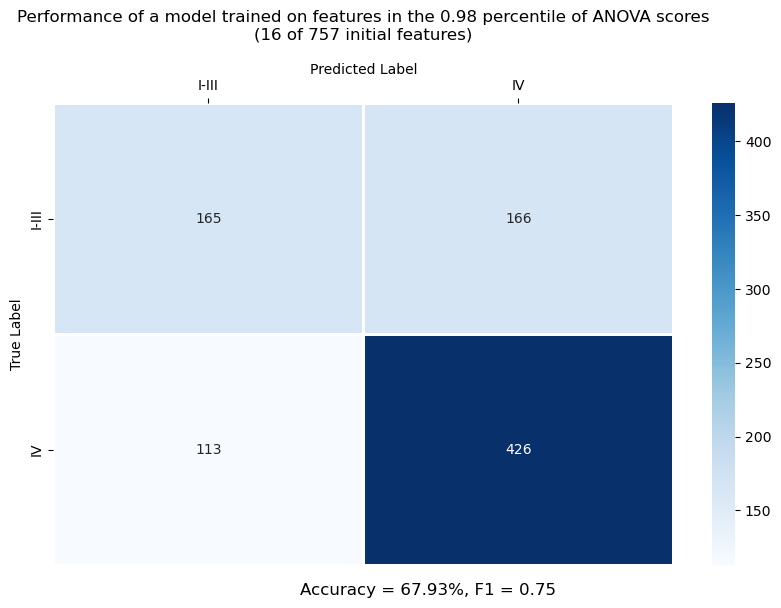

In [16]:
for percentile in percentiles:
    features_indices = select_by_percentile(f_scores_binary, percentile)
    best_features = X_train_dr_binary.columns[features_indices].tolist()
    X_train_reducted = X_train_binary.loc[:, best_features + ['Stage']]

    objective_func = partial(
        objective,
        X_train=X_train_reducted,
        stratification_groups=stratification_groups_binary,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reducted,
        stratification_groups=stratification_groups_binary,
        label_col='Stage',
        n_splits=5
    )
    y_true = list(X_train_reducted['Stage'].values)
    labels = list(labels_encoding_binary.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int))
    cm = confusion_matrix(y_true, y_pred.astype(int))

    title = f'Performance of a model trained on features in the {percentile/100:.2f} percentile of ANOVA scores' \
            f'\n({len(features_indices[0])} of {len(X_train_dr_binary.columns)} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
    
    filename = f'anova_{percentile}_percentile.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

## Mutual information

Preselection of features based on mutual information scores with different percentile thresholds. For each threshold, an XGBoost model is trained, fine-tuned, and cross-validated on the subset of initial columns.

### Multiclass classification

In [17]:
mi_scores_multiclass = mutual_info_classif(X_train_dr_multiclass, y_train_dr_multiclass, n_neighbors=3)

results_mi_multiclass = pd.DataFrame(data={
    'feature': X_train_dr_multiclass.columns,
    'mi_score': mi_scores_multiclass
})

results_mi_multiclass.sort_values('mi_score', ascending=False).reset_index(drop=True).head(10)

,feature,mi_score
0,CABP5,0.077312
1,TMEM258,0.065241
2,DNAH12,0.062340
3,FLI1,0.059073
4,CHD3,0.057372
5,NBEAL2,0.055639
6,LMBRD1,0.054496
7,SCFD2,0.054049
8,H3F3A,0.051056
9,AP2A1,0.050911


In [18]:
percentiles = [70, 80, 90, 95, 98]

xgb_config = {
    'objective': 'multi:softmax',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
    'num_class': 4,
}

scoring_func = partial(f1_score, average='weighted')

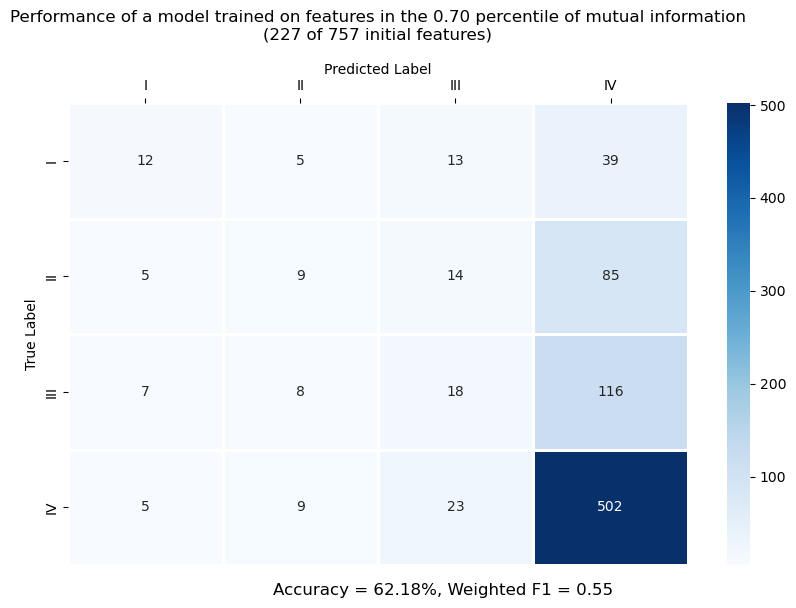

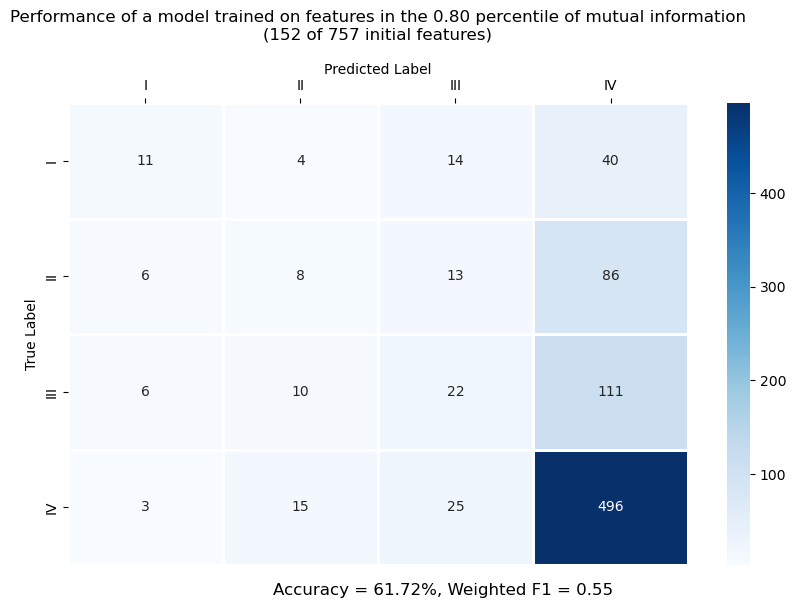

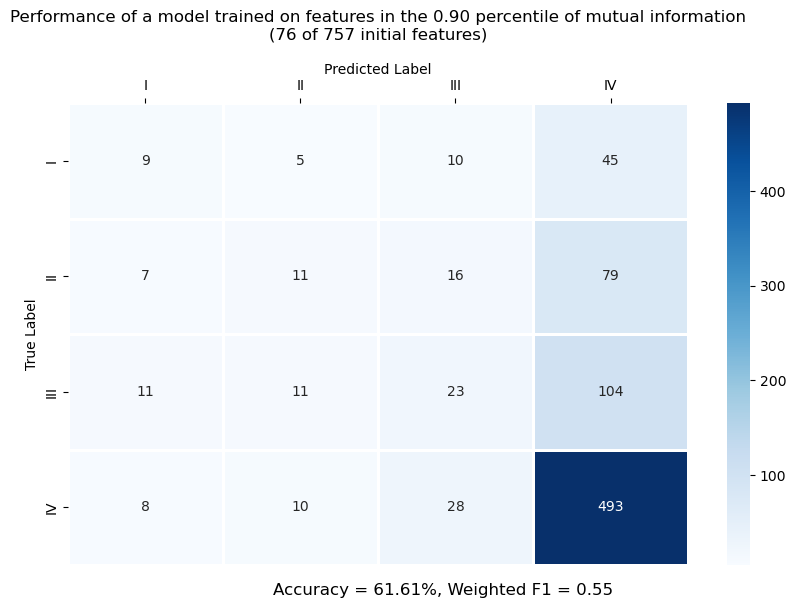

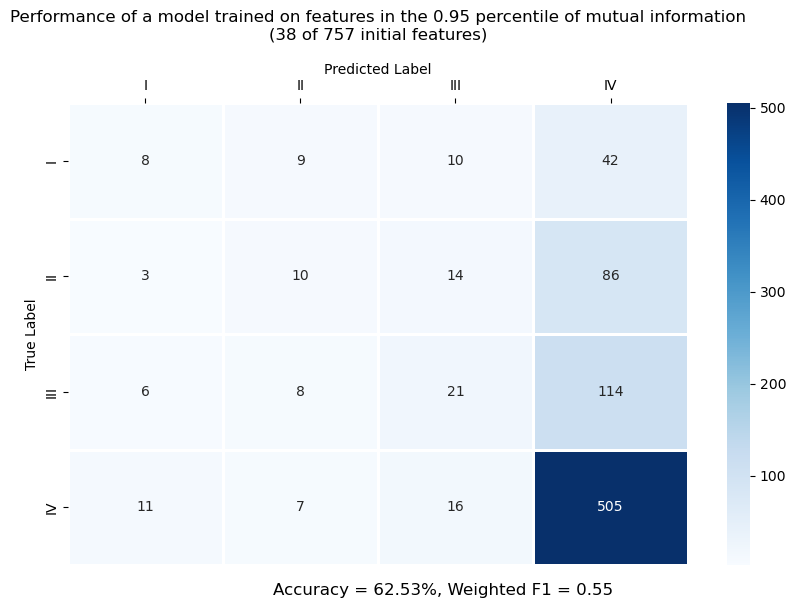

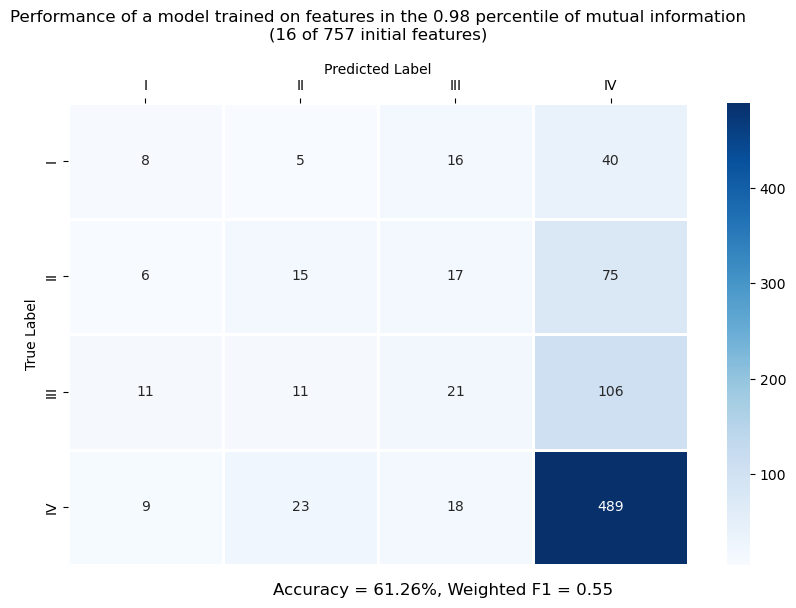

In [19]:
for percentile in percentiles:
    features_indices = select_by_percentile(mi_scores_multiclass, percentile)
    best_features = X_train_dr_multiclass.columns[features_indices].tolist()
    X_train_reducted = X_train_multiclass.loc[:, best_features + ['Stage']]

    objective_func = partial(
        objective,
        X_train=X_train_reducted,
        stratification_groups=stratification_groups_multiclass,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reducted,
        stratification_groups=stratification_groups_multiclass,
        label_col='Stage',
        n_splits=5
    )
    y_true = list(X_train_reducted['Stage'].values)
    labels = list(labels_encoding_multiclass.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    title = f'Performance of a model trained on features in the {percentile/100:.2f} percentile of mutual information' \
            f'\n({len(features_indices[0])} of {len(X_train_dr_multiclass.columns)} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'
    
    filename = f'mutual_information_{percentile}_percentile.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

### Binary classification

In [20]:
mi_scores_binary = mutual_info_classif(X_train_dr_binary, y_train_dr_binary, n_neighbors=3)

results_mi_binary = pd.DataFrame(data={
    'feature': X_train_dr_binary.columns,
    'mi_score': mi_scores_binary
})

results_mi_binary.sort_values('mi_score', ascending=False).reset_index(drop=True).head(10)

,feature,mi_score
0,CABP5,0.073460
1,AP2A1,0.061672
2,HCST,0.053414
3,FLI1,0.052785
4,ITGB3BP,0.052036
5,NDUFB4,0.051662
6,LSM1,0.050041
7,DNAJB6,0.045692
8,LAPTM5,0.043809
9,ANK1,0.043271


In [21]:
percentiles = [70, 80, 90, 95, 98]

xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

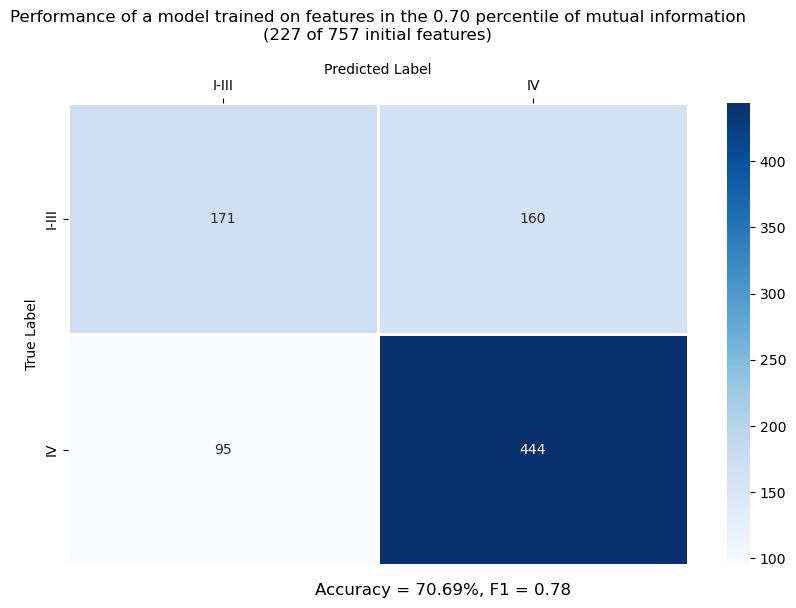

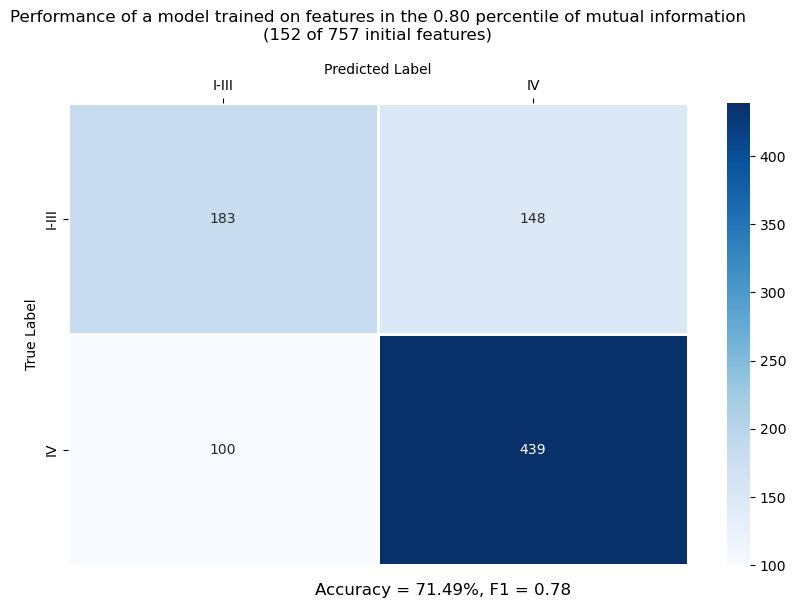

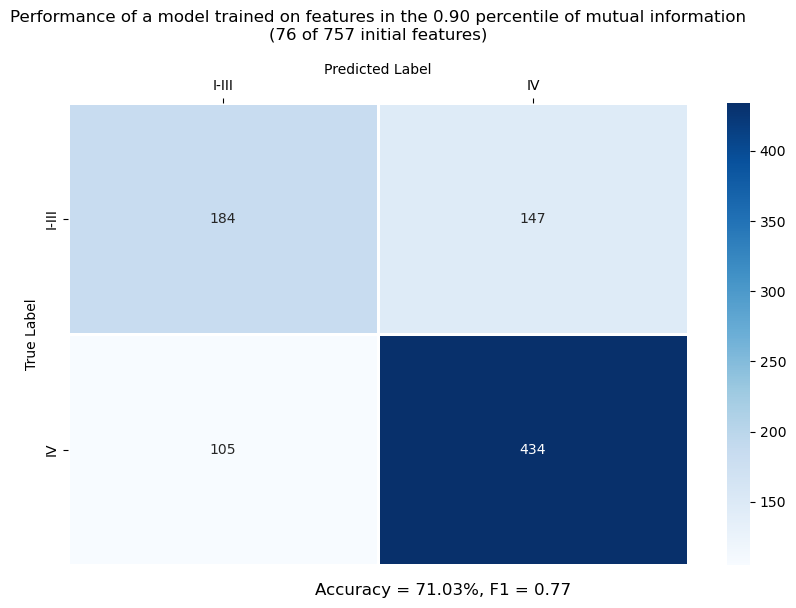

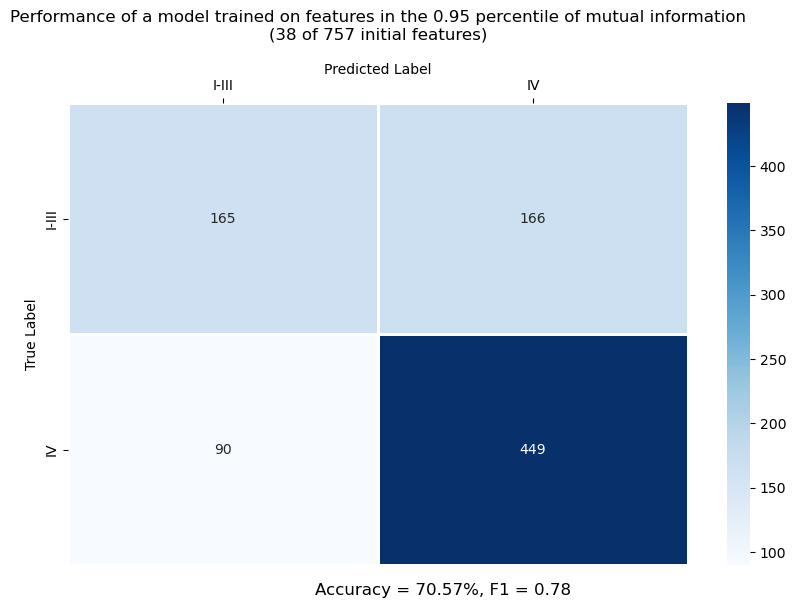

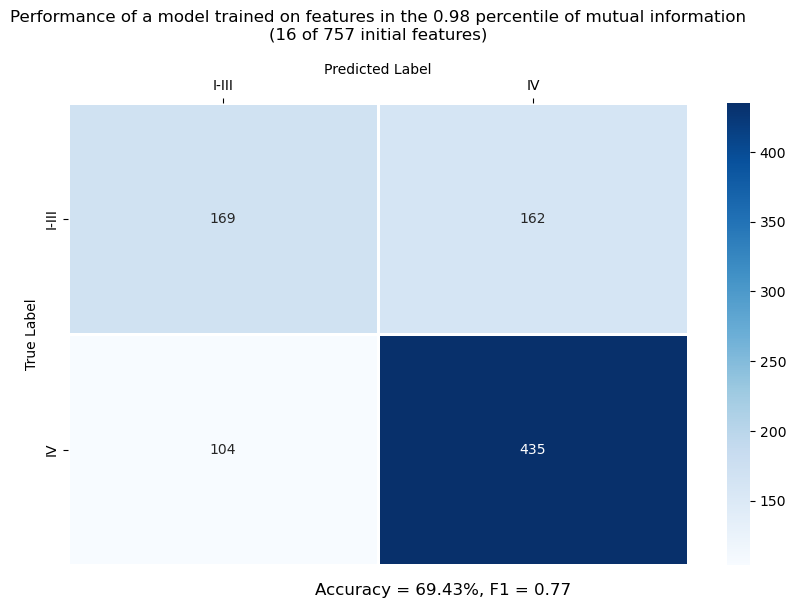

In [22]:
for percentile in percentiles:
    features_indices = select_by_percentile(mi_scores_binary, percentile)
    best_features = X_train_dr_binary.columns[features_indices].tolist()
    X_train_reducted = X_train_binary.loc[:, best_features + ['Stage']]

    objective_func = partial(
        objective,
        X_train=X_train_reducted,
        stratification_groups=stratification_groups_binary,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reducted,
        stratification_groups=stratification_groups_binary,
        label_col='Stage',
        n_splits=5
    )
    y_true = list(X_train_reducted['Stage'].values)
    labels = list(labels_encoding_binary.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int))
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    title = f'Performance of a model trained on features in the {percentile/100:.2f} percentile of mutual information' \
            f'\n({len(features_indices[0])} of {len(X_train_dr_binary.columns)} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
    
    filename = f'mutual_information_{percentile}_percentile.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

## PCA

Decomposition of input features using PCA with different percentage thresholds of explained variance. For each threshold, an XGBoost model is trained, fine-tuned, and cross-validated on obtained components.

### Multiclass classification

In [23]:
explained_variance_thresholds = [0.7, 0.8, 0.9, 0.95, 0.98]

xgb_config = {
    'objective': 'multi:softmax',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
    'num_class': 4,
}

scoring_func = partial(f1_score, average='weighted')

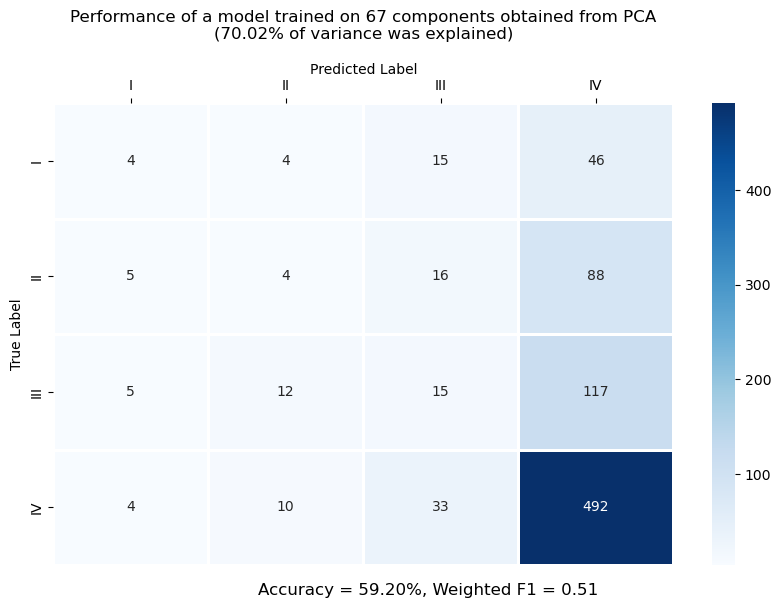

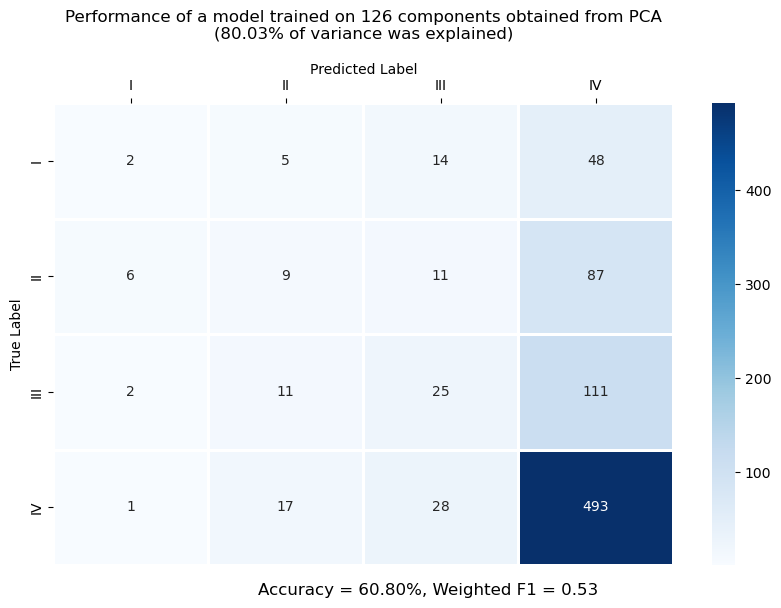

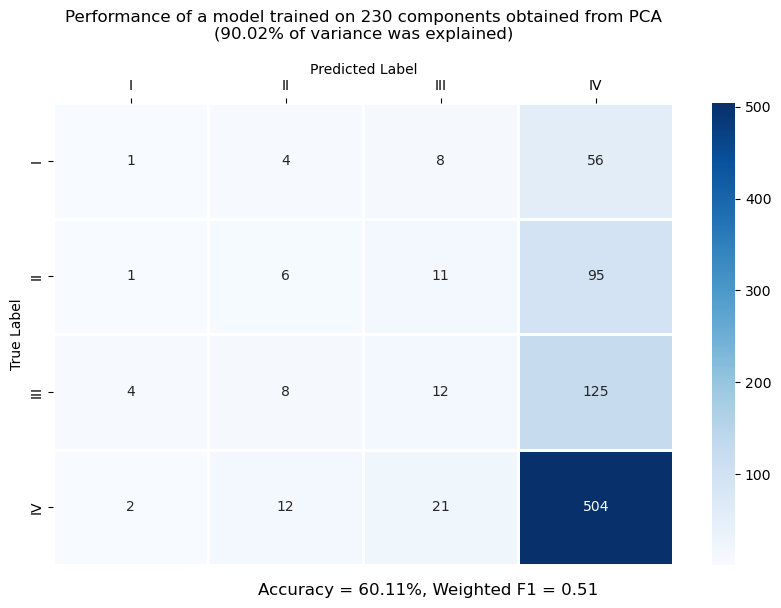

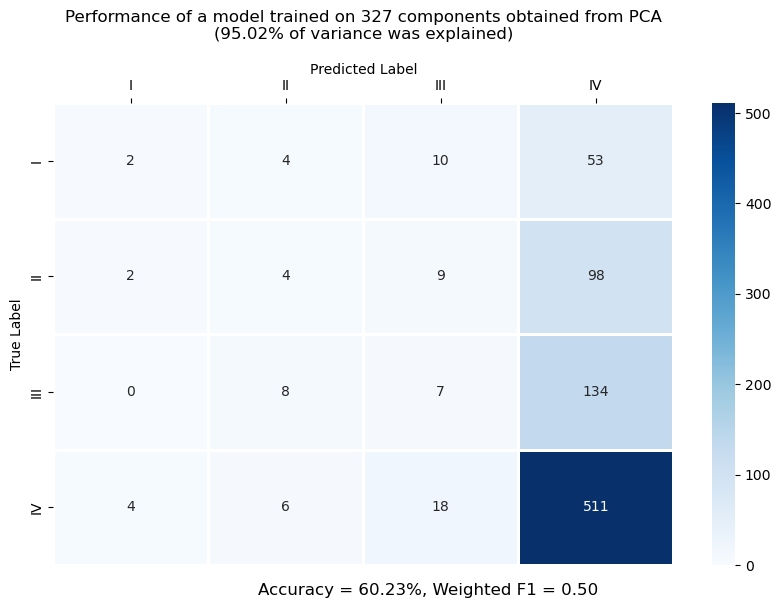

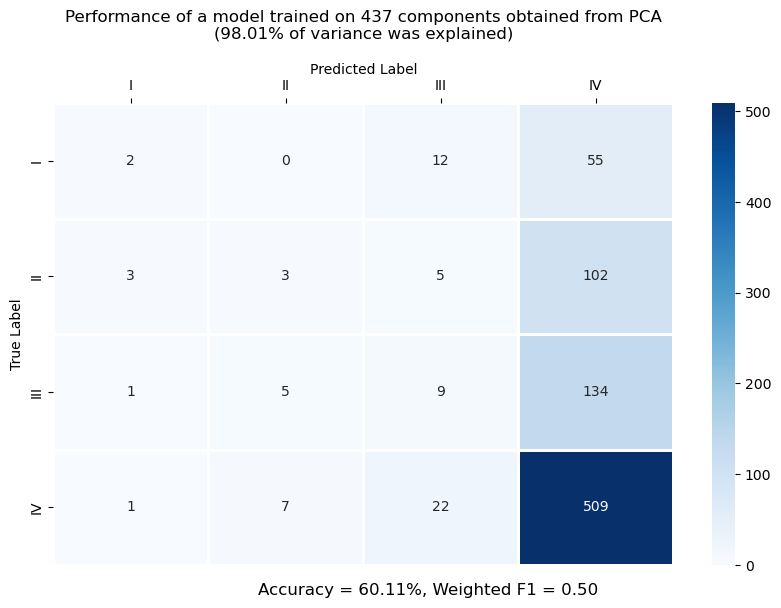

In [24]:
for explained_variance in explained_variance_thresholds:
    pca = PCA(n_components=explained_variance, random_state=random_state)
    X_train_reducted = pca.fit_transform(X_train_dr_multiclass)
    X_train_reducted = pd.DataFrame(X_train_reducted)
    X_train_reducted['Stage'] = X_train_multiclass['Stage'].values

    objective_func = partial(
        objective,
        X_train=X_train_reducted,
        stratification_groups=stratification_groups_multiclass,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reducted,
        stratification_groups=stratification_groups_multiclass,
        label_col='Stage',
        n_splits=5
    )
    y_true = list(X_train_reducted['Stage'].values)
    labels = list(labels_encoding_multiclass.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    variance_explained = pca.explained_variance_ratio_.sum() * 100
    title = f'Performance of a model trained on {pca.n_components_} components obtained from PCA' \
            f'\n({variance_explained:.2f}% of variance was explained)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'
    
    filename = f'pca_{int(variance_explained)}%_variance.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

### Binary classification

In [25]:
explained_variance_thresholds = [0.7, 0.8, 0.9, 0.95, 0.98]

xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

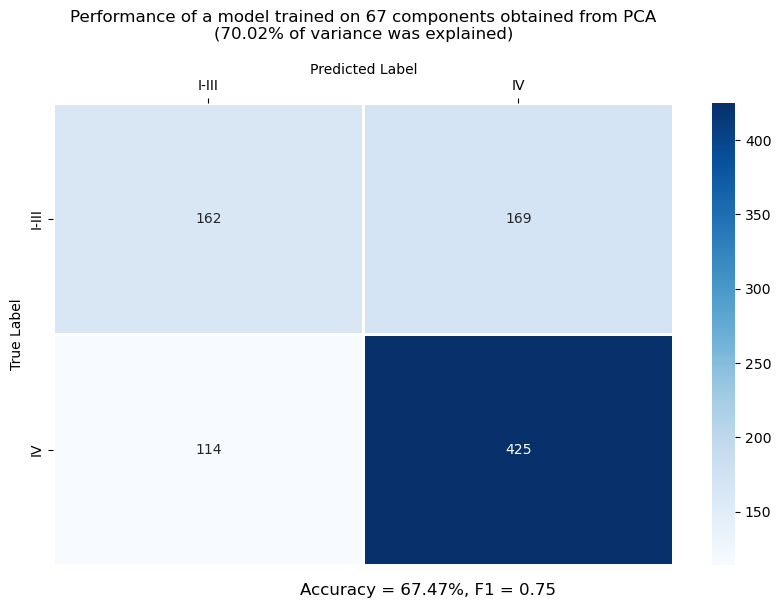

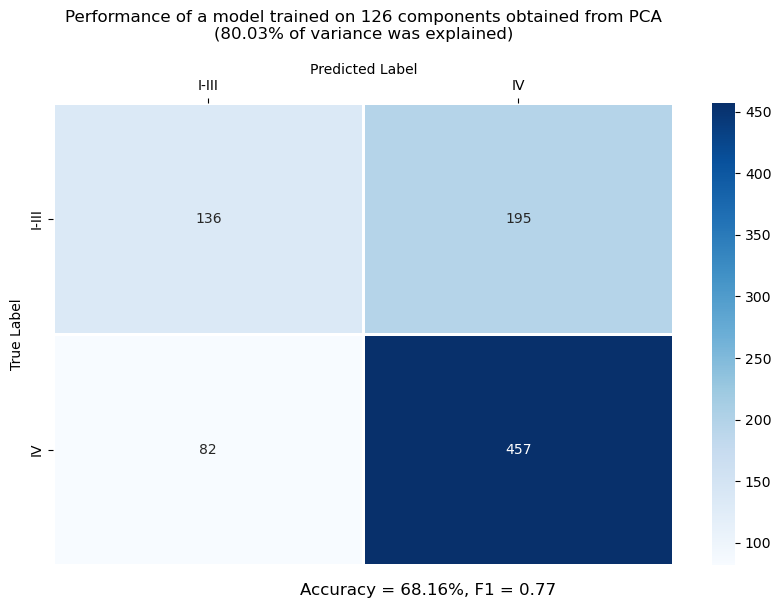

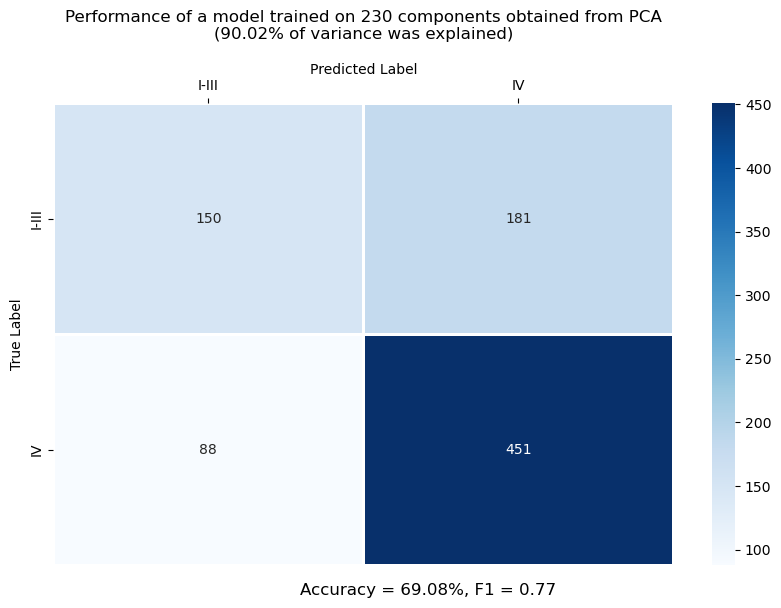

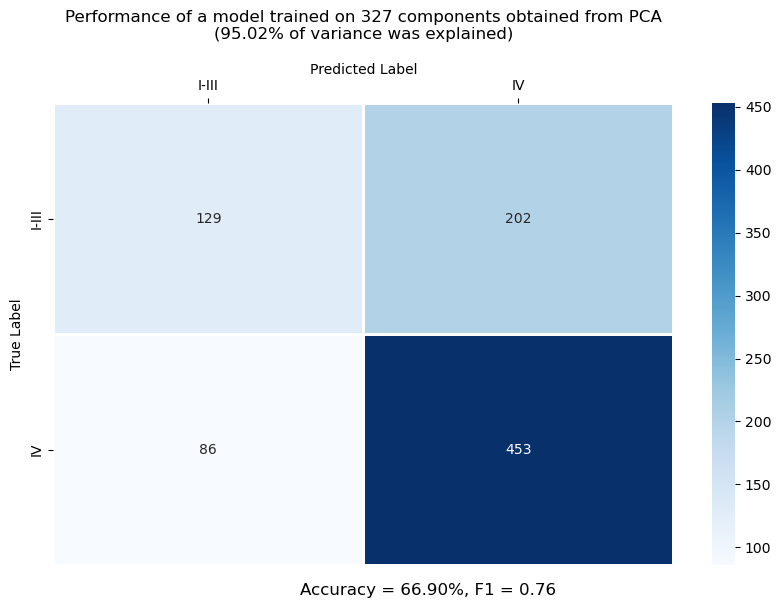

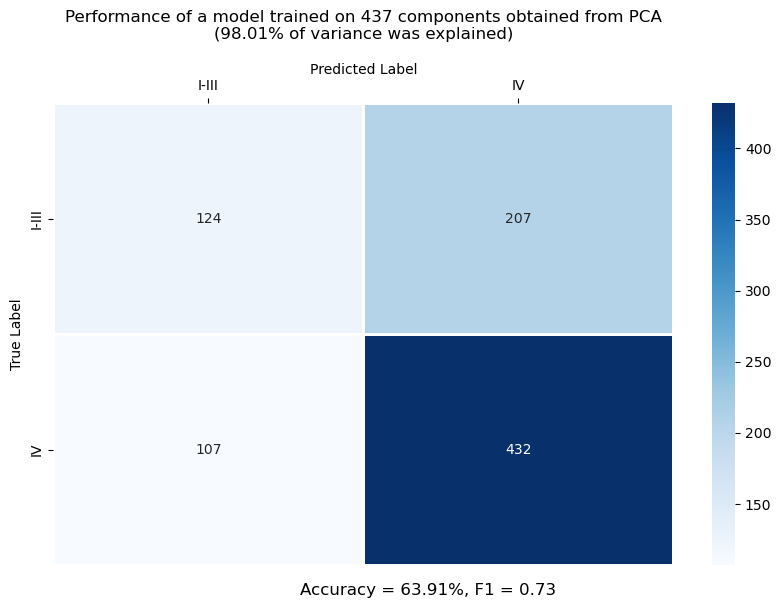

In [26]:
for explained_variance in explained_variance_thresholds:
    pca = PCA(n_components=explained_variance, random_state=random_state)
    X_train_reducted = pca.fit_transform(X_train_dr_binary)
    X_train_reducted = pd.DataFrame(X_train_reducted)
    X_train_reducted['Stage'] = X_train_binary['Stage'].values

    objective_func = partial(
        objective,
        X_train=X_train_reducted,
        stratification_groups=stratification_groups_binary,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reducted,
        stratification_groups=stratification_groups_binary,
        label_col='Stage',
        n_splits=5
    )
    y_true = list(X_train_reducted['Stage'].values)
    labels = list(labels_encoding_binary.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int))
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    variance_explained = pca.explained_variance_ratio_.sum() * 100
    title = f'Performance of a model trained on {pca.n_components_} components obtained from PCA' \
            f'\n({variance_explained:.2f}% of variance was explained)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
    
    filename = f'pca_{int(variance_explained)}%_variance.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

## Combined criteria

Preselection of features based on combined criteria of ANOVA and mutual information with different percentile thresholds. For each threshold, an XGBoost model is trained, fine-tuned, and cross-validated on the subset of initial columns.

### Multiclass classification

In [27]:
anova_features_order = np.zeros(f_scores_multiclass.size, dtype=int)
anova_features_order[np.argsort(f_scores_multiclass)] = np.arange(f_scores_multiclass.size)

mi_features_order = np.zeros(mi_scores_multiclass.size, dtype=int)
mi_features_order[np.argsort(mi_scores_multiclass)] = np.arange(mi_scores_multiclass.size)

features_order = anova_features_order + mi_features_order
results_combined_criteria = pd.DataFrame(data={
    'feature': X_train_dr_multiclass.columns,
    'order': features_order
})
results_combined_criteria.sort_values('order', ascending=False).reset_index(drop=True).head(10)

,feature,order
0,CABP5,1510
1,TMEM258,1508
2,H3F3A,1498
3,HCST,1493
4,SCFD2,1490
5,NDUFB4,1482
6,ZFYVE21,1472
7,DSTN,1468
8,HIST1H2BH,1456
9,CALM1,1456


In [28]:
percentiles = [70, 80, 90, 95, 98]

xgb_config = {
    'objective': 'multi:softmax',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
    'num_class': 4,
}

scoring_func = partial(f1_score, average='weighted')

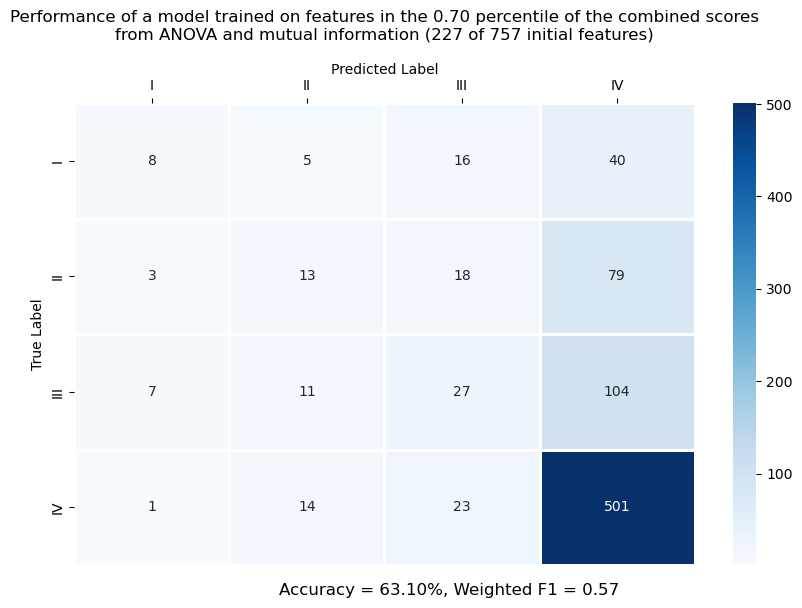

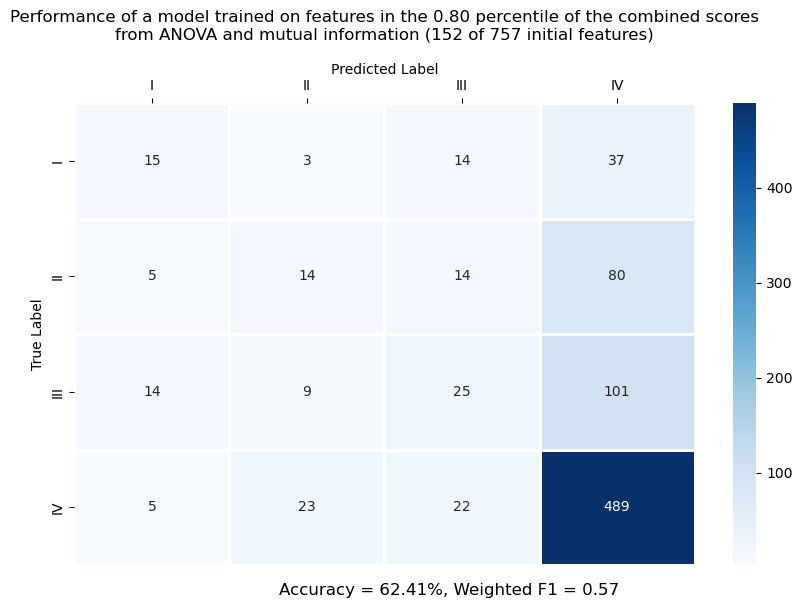

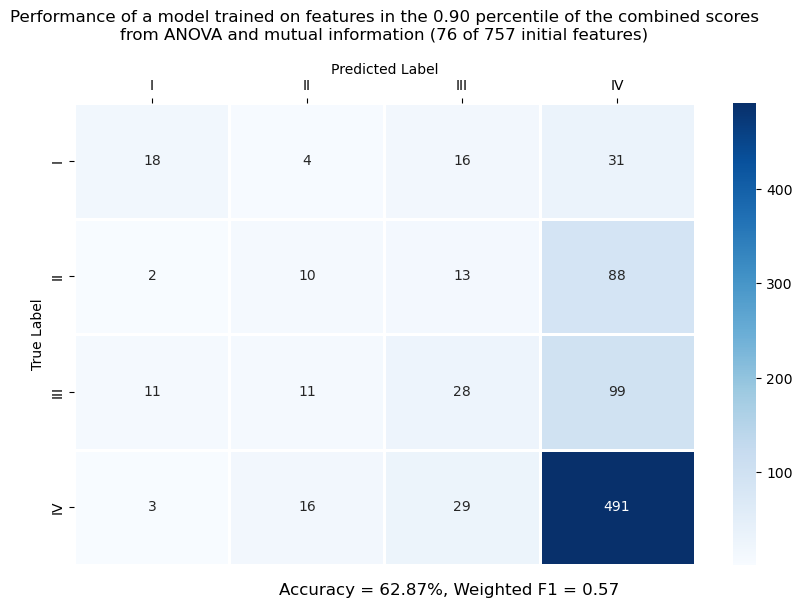

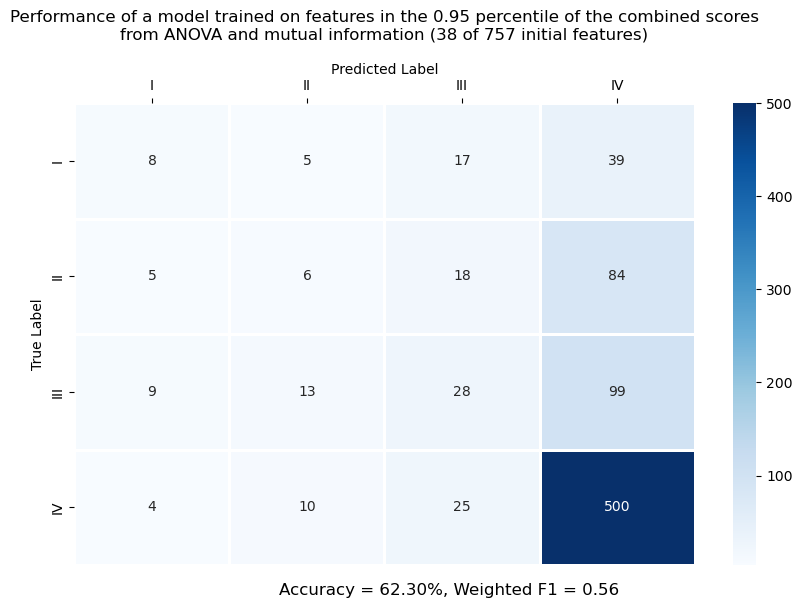

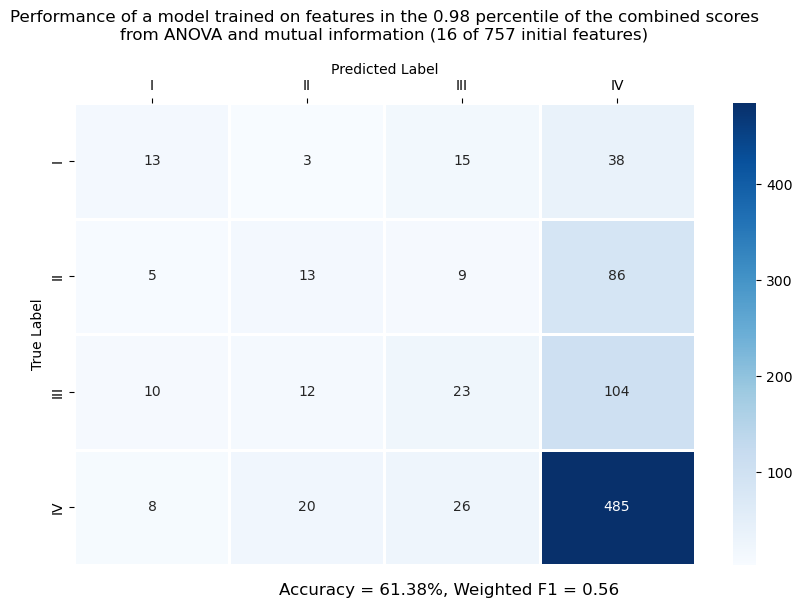

In [29]:
for percentile in percentiles:
    features_indices = select_by_percentile(features_order, percentile)
    best_features = X_train_dr_multiclass.columns[features_indices].tolist()
    X_train_reducted = X_train_multiclass.loc[:, best_features + ['Stage']]

    objective_func = partial(
        objective,
        X_train=X_train_reducted,
        stratification_groups=stratification_groups_multiclass,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reducted,
        stratification_groups=stratification_groups_multiclass,
        label_col='Stage',
        n_splits=5
    )
    y_true = list(X_train_reducted['Stage'].values)
    labels = list(labels_encoding_multiclass.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    title = f'Performance of a model trained on features in the {percentile/100:.2f} percentile of the combined scores' \
            f'\nfrom ANOVA and mutual information ({len(features_indices[0])} of {len(X_train_dr_multiclass.columns)} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'
    
    filename = f'combined_criteria_{percentile}_percentile.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

### Binary classification

In [30]:
anova_features_order = np.zeros(f_scores_binary.size, dtype=int)
anova_features_order[np.argsort(f_scores_binary)] = np.arange(f_scores_binary.size)

mi_features_order = np.zeros(mi_scores_binary.size, dtype=int)
mi_features_order[np.argsort(mi_scores_binary)] = np.arange(mi_scores_binary.size)

features_order = anova_features_order + mi_features_order

results_combined_criteria = pd.DataFrame(data={
    'feature': X_train_dr_binary.columns,
    'order': features_order
})
results_combined_criteria.sort_values('order', ascending=False).reset_index(drop=True).head(10)

,feature,order
0,CABP5,1512
1,HCST,1500
2,NOMO1,1499
3,NDUFB4,1493
4,H3F3A,1481
5,TMEM258,1458
6,KIFAP3,1455
7,LSM1,1454
8,TBL1X,1454
9,B2M,1450


In [31]:
percentiles = [70, 80, 90, 95, 98]

xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

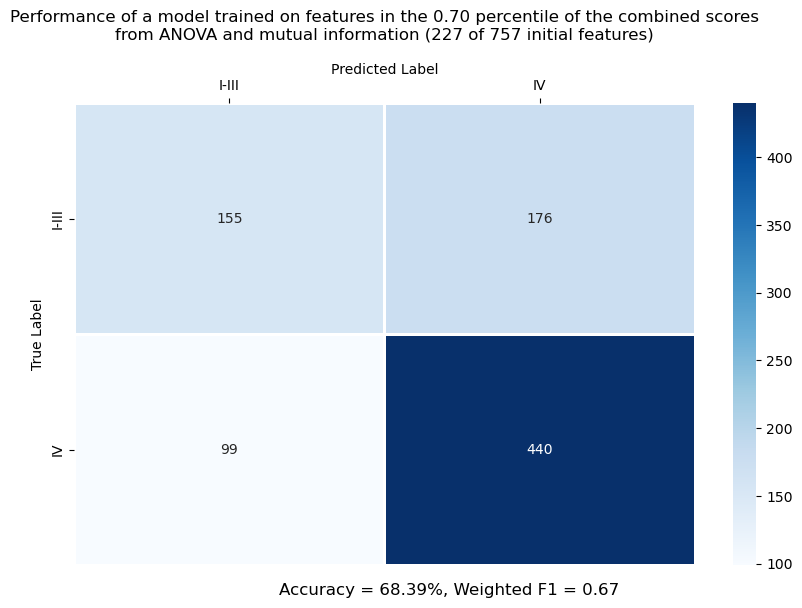

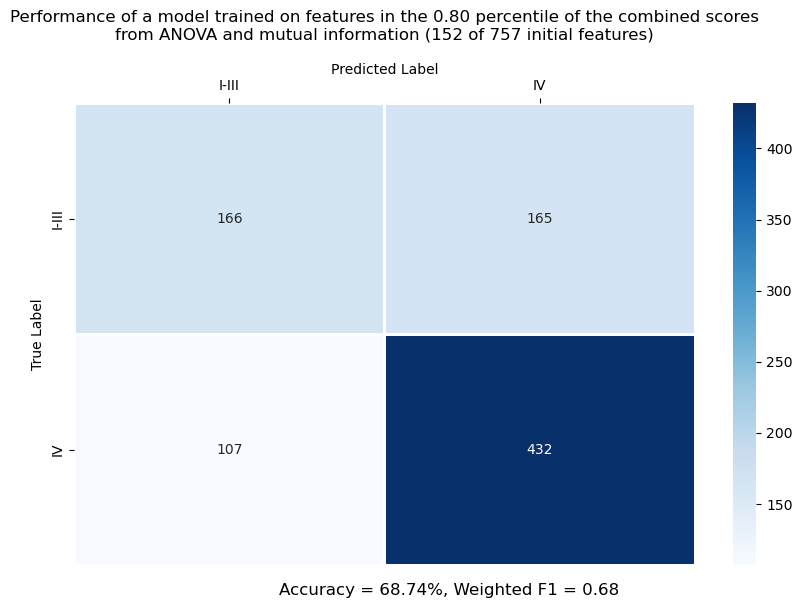

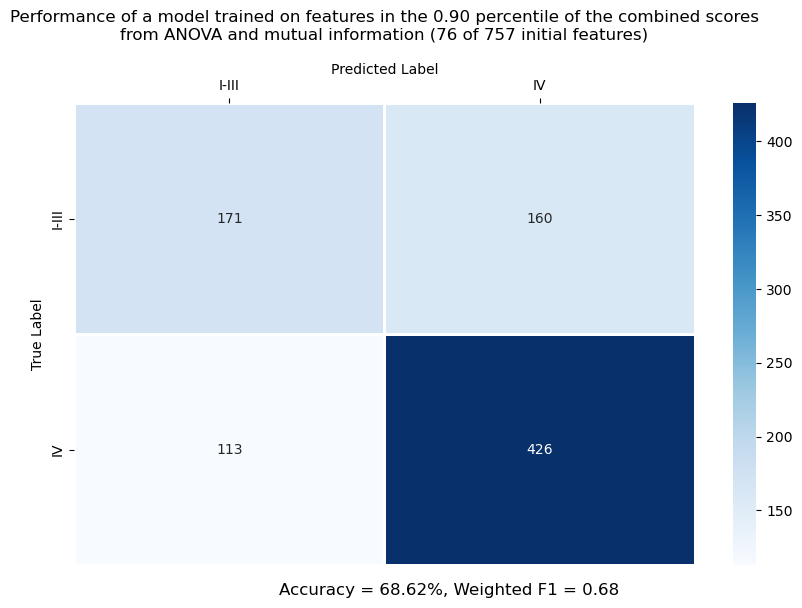

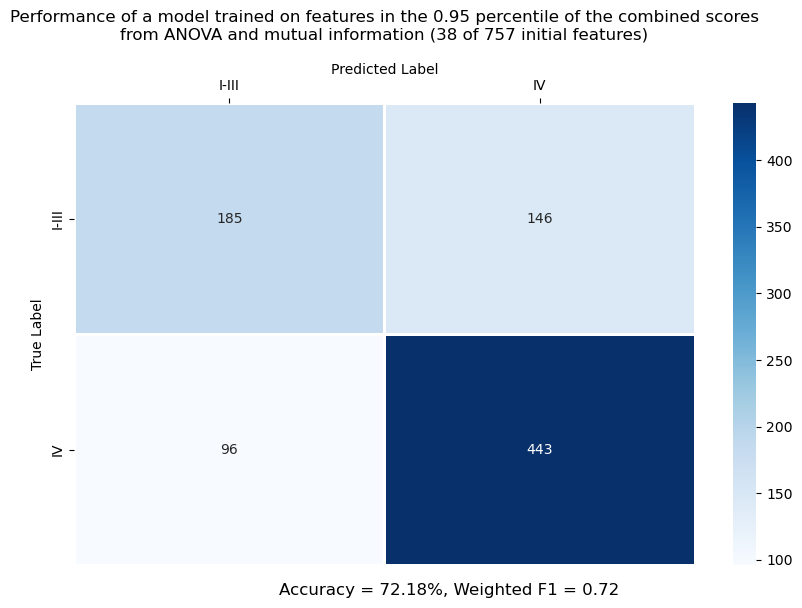

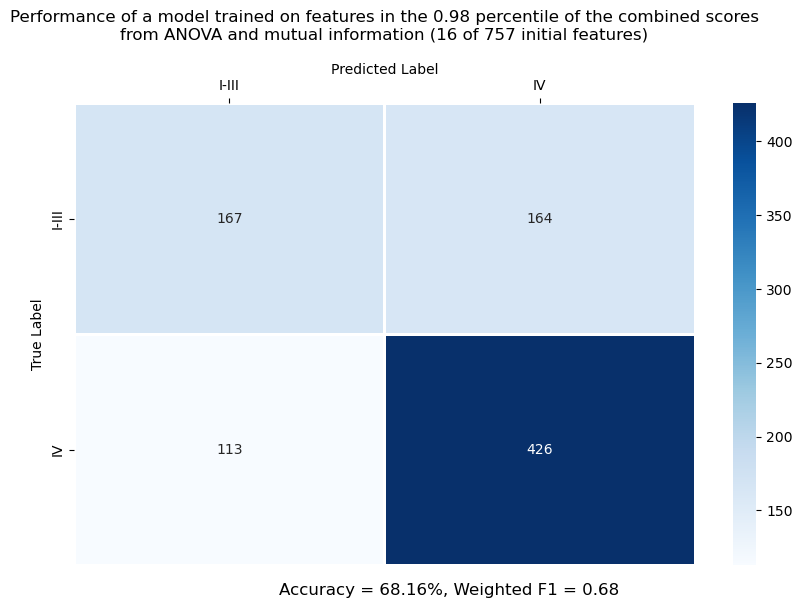

In [32]:
for percentile in percentiles:
    features_indices = select_by_percentile(features_order, percentile)
    best_features = X_train_dr_binary.columns[features_indices].tolist()
    X_train_reducted = X_train_binary.loc[:, best_features + ['Stage']]

    objective_func = partial(
        objective,
        X_train=X_train_reducted,
        stratification_groups=stratification_groups_binary,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reducted,
        stratification_groups=stratification_groups_binary,
        label_col='Stage',
        n_splits=5
    )
    y_true = list(X_train_reducted['Stage'].values)
    labels = list(labels_encoding_binary.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    title = f'Performance of a model trained on features in the {percentile/100:.2f} percentile of the combined scores' \
            f'\nfrom ANOVA and mutual information ({len(features_indices[0])} of {len(X_train_dr_binary.columns)} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'
    
    filename = f'combined_criteria_{percentile}_percentile.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))